# imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from os.path import basename, exists
from tiffile import imread
import laserbeamsize as lbs
import matplotlib as mpl
import re
import xarray as xr
import dask.array as da
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, progress
import sys
import multiprocessing as mp
from scipy.ndimage import gaussian_filter
from lmfit.models import Gaussian2dModel
from lmfit import Model, Parameter
from lmfit.lineshapes import gaussian, lorentzian
mpl.rcParams['font.size'] = 20
import pandas as pd

# load data

In [3]:
file = '../data/200.0K_reduced.h5'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:      (time: 2048, row: 800, col: 800)
Coordinates:
  * time         (time) int32 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
  * row          (row) int32 0 1 2 3 4 5 6 7 ... 792 793 794 795 796 797 798 799
  * col          (col) int32 0 1 2 3 4 5 6 7 ... 792 793 794 795 796 797 798 799
Data variables:
    image_stack  (time, row, col) float32 ...
Attributes:
    temperature:  200.0

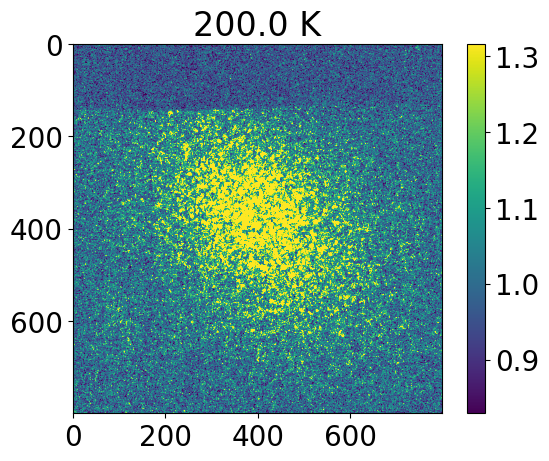

In [4]:
img = ds['image_stack'][1].compute().to_numpy()
plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(img, vmin=np.percentile(img, 10), vmax=np.percentile(img, 90))
plt.colorbar()
plt.show()

# fit peak

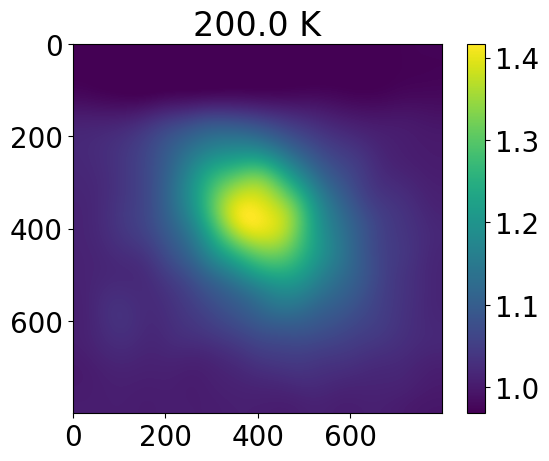

In [5]:
gimg = gaussian_filter(img, 35)

plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(gimg, vmin=np.percentile(gimg, 10), vmax=np.percentile(gimg, 100))
plt.colorbar()
plt.show()

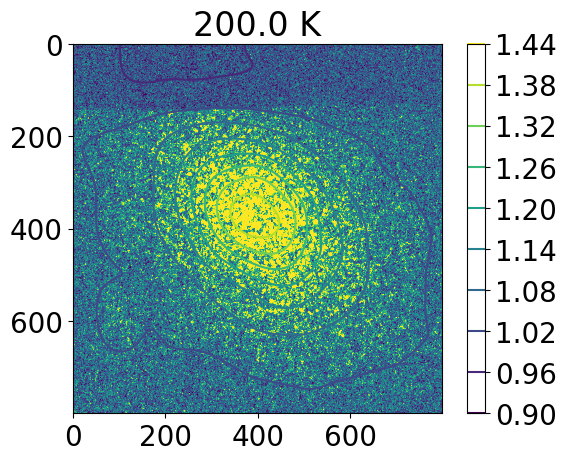

In [6]:
plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(img, vmin=np.percentile(img, 10), vmax=np.percentile(img, 90))
plt.contour(gimg)
plt.colorbar()
plt.show()

In [7]:
# https://lmfit.github.io/lmfit-py/examples/example_two_dimensional_peak.html
def lorentzian2d(x, y, amplitude=1., centerx=0., centery=0., sigmax=1., sigmay=1.,
                 rotation=0, offset = 0):
    """Return a two dimensional lorentzian.

    The maximum of the peak occurs at ``centerx`` and ``centery``
    with widths ``sigmax`` and ``sigmay`` in the x and y directions
    respectively. The peak can be rotated by choosing the value of ``rotation``
    in radians.
    """
    xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
    yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
    R = (xp/sigmax)**2 + (yp/sigmay)**2

    return 2*amplitude*lorentzian(R)/(np.pi*sigmax*sigmay) + offset

x, y = np.indices(gimg.shape)
mod = Model(lorentzian2d, independent_vars=['x', 'y'])
params = mod.make_params(amplitude=1)
params['rotation'].set(value=1, min=0, max=np.pi/2)
params['sigmax'].set(value=50, min=0, max=500)
params['sigmay'].set(value=100, min=0, max=500)
params['centery'].set(value=384, min=200, max=500)
params['centerx'].set(value=374, min=200, max=500)
params['offset'].set(value=1)

error = 1 / np.sqrt(gimg).ravel()
result = mod.fit(img.ravel(), x=x.ravel(), y=y.ravel(), params=params, weights=1/error)

In [8]:
result

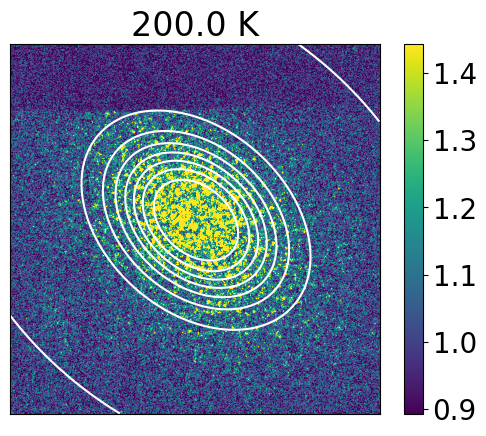

In [9]:
fit = mod.func(x, y, **result.best_values)

plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(img, vmin=np.percentile(img, 20), vmax=np.percentile(img, 95))
plt.colorbar()
plt.contour(fit, colors=['w'])
plt.xticks([])
plt.yticks([])
plt.show()

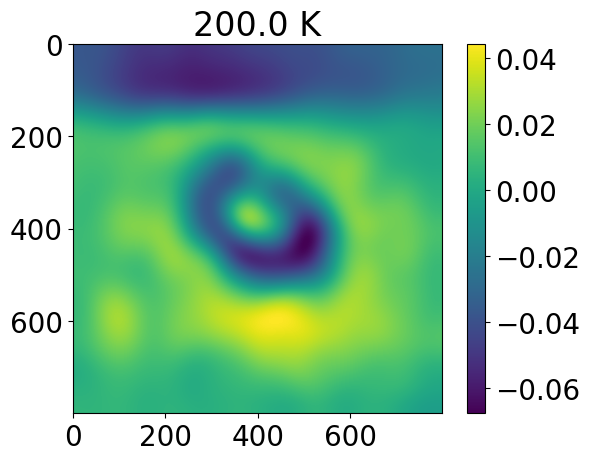

In [10]:
plt.figure()
plt.title(f'{ds.attrs["temperature"]} K')
plt.imshow(gimg-fit)#, vmin=np.percentile(img, 10), vmax=np.percentile(img, 90))
plt.colorbar()
plt.show()


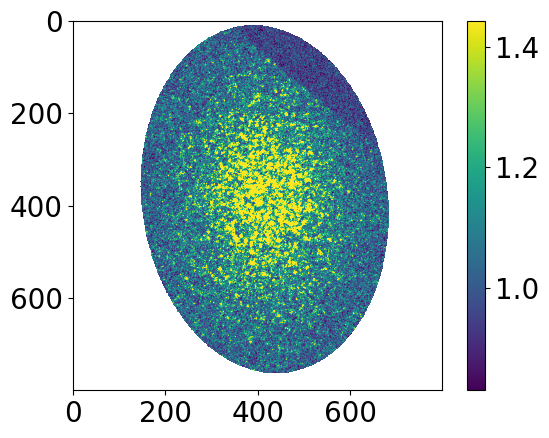

In [11]:
from scipy.ndimage import rotate

rimg = img.copy()
rimg[fit<np.percentile(fit, 50)] = -5
rimg = rotate(rimg, -np.rad2deg(result.best_values['rotation']), reshape=False, cval=np.nan)
rimg[rimg<0] = np.nan

plt.figure()
plt.imshow(rimg, vmin=np.percentile(img, 10), vmax=np.percentile(img, 95))
plt.colorbar()
plt.show()

C:\Users\rtumbleson\AppData\Local\Temp\ipykernel_11612\3511152131.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.arange(len( np.nanmean(rimg, axis=0)[150:-150])) + 150, np.nanmean(rimg, axis=0)[150:-150])
C:\Users\rtumbleson\AppData\Local\Temp\ipykernel_11612\3511152131.py:3: RuntimeWarning: Mean of empty slice
  plt.plot(range(len( np.nanmean(rimg, axis=1))), np.nanmean(rimg, axis=1))


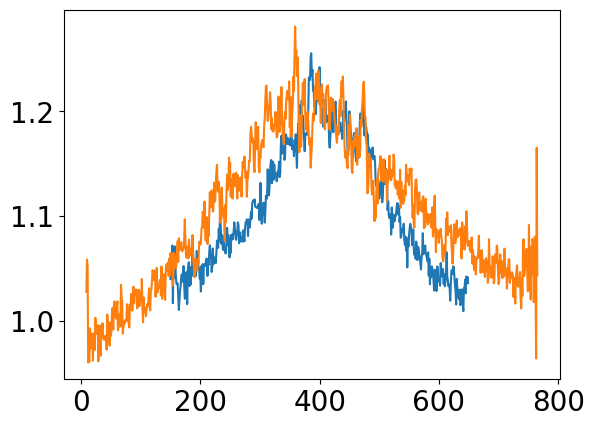

In [12]:
plt.figure()
plt.plot(np.arange(len( np.nanmean(rimg, axis=0)[150:-150])) + 150, np.nanmean(rimg, axis=0)[150:-150])
plt.plot(range(len( np.nanmean(rimg, axis=1))), np.nanmean(rimg, axis=1))
plt.show()

# loop

In [13]:
files = sorted(glob('../data/*_reduced.h5'))
files

['../data\\200.0K_reduced.h5',
 '../data\\225.0K_reduced.h5',
 '../data\\230.0K_reduced.h5',
 '../data\\230.5K_reduced.h5',
 '../data\\231.0K_reduced.h5',
 '../data\\232.0K_reduced.h5']

In [14]:
# https://lmfit.github.io/lmfit-py/examples/example_two_dimensional_peak.html
def lorentzian2d(x, y, amplitude=1., centerx=0., centery=0., sigmax=1., sigmay=1.,
                 rotation=0, offset = 0):
    """Return a two dimensional lorentzian.

    The maximum of the peak occurs at ``centerx`` and ``centery``
    with widths ``sigmax`` and ``sigmay`` in the x and y directions
    respectively. The peak can be rotated by choosing the value of ``rotation``
    in radians.
    """
    xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
    yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
    R = (xp/sigmax)**2 + (yp/sigmay)**2

    return 2*amplitude*lorentzian(R)/(np.pi*sigmax*sigmay) + offset


In [21]:
ds = xr.open_dataset(files[1])
img = ds['image_stack'][:].compute().to_numpy()

  0%|          | 0/6 [00:00<?, ?it/s]

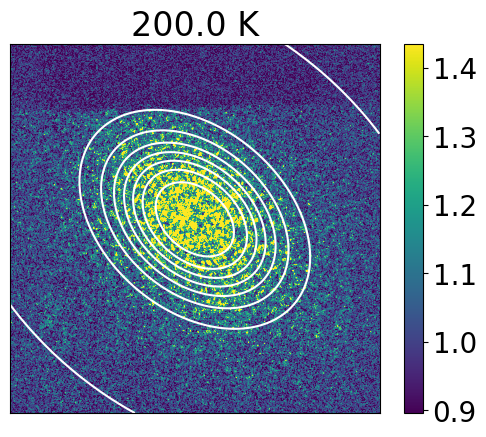

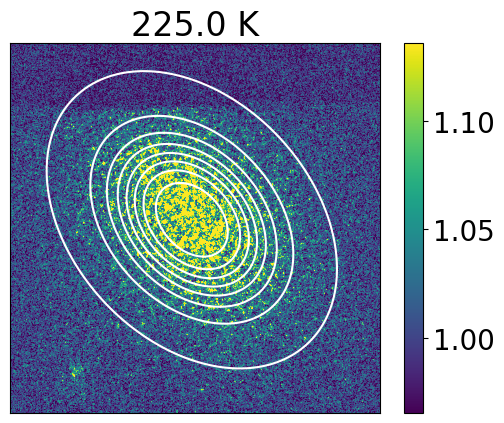

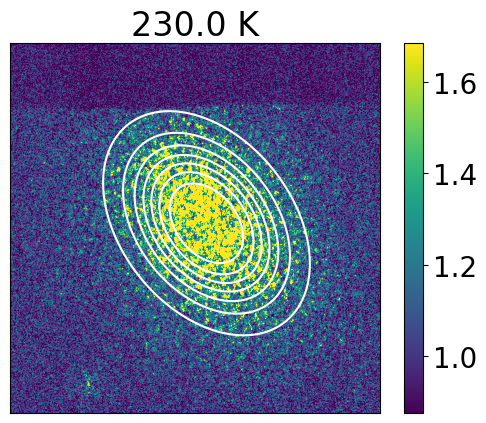

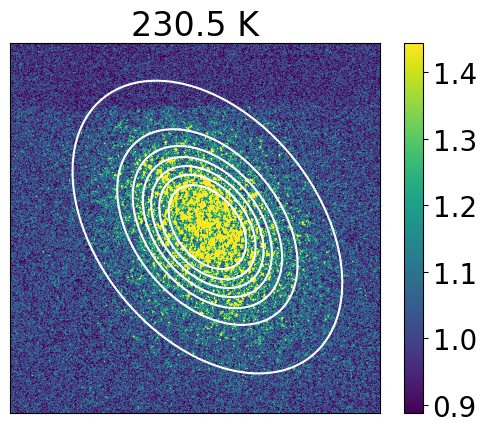

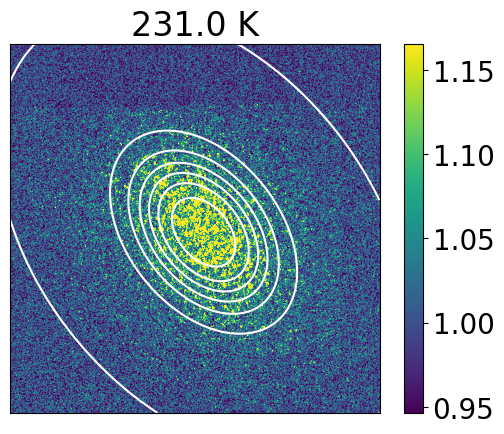

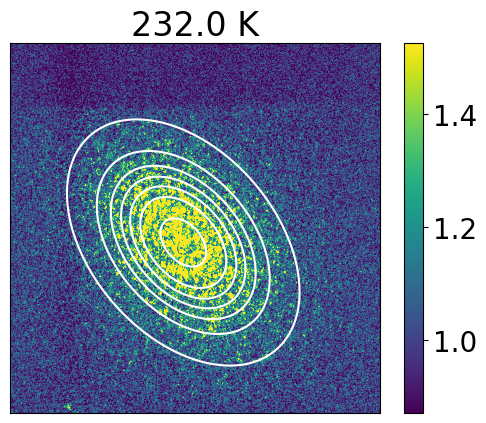

In [23]:
out = []
for f in tqdm(files):
    ds = xr.open_dataset(f)
    img = ds['image_stack'][10].compute().to_numpy()
    gimg = gaussian_filter(img, 35)
    

    x, y = np.indices(gimg.shape)
    mod = Model(lorentzian2d, independent_vars=['x', 'y'])
    params = mod.make_params(amplitude=1)
    params['rotation'].set(value=1, min=0, max=np.pi/2)
    params['sigmax'].set(value=50, min=0, max=500)
    params['sigmay'].set(value=100, min=0, max=500)
    params['centery'].set(value=384, min=200, max=500)
    params['centerx'].set(value=374, min=200, max=500)
    params['offset'].set(value=1)

    error = 1 / np.sqrt(gimg).ravel()
    result = mod.fit(img.ravel(), x=x.ravel(), y=y.ravel(), params=params, weights=1/error)

    fit = mod.func(x, y, **result.best_values)

    plt.figure()
    plt.title(f'{ds.attrs["temperature"]} K')
    plt.imshow(img, vmin=np.percentile(img, 20), vmax=np.percentile(img, 95))
    plt.colorbar()
    plt.contour(fit, colors=['w'])
    plt.xticks([])
    plt.yticks([])
    plt.show()

    iter_dict = result.params.valuesdict()
    iter_dict['rotation_error'] = result.params['rotation'].stderr
    iter_dict['amplitude_error'] = result.params['amplitude'].stderr
    iter_dict['sigmax_error'] = result.params['sigmax'].stderr
    iter_dict['sigmay_error'] = result.params['sigmay'].stderr
    iter_dict['centerx_error'] = result.params['centerx'].stderr
    iter_dict['centery_error'] = result.params['centery'].stderr
    iter_dict['offset_error'] = result.params['offset'].stderr
    iter_dict['temperature'] = ds.attrs["temperature"]

    out.append(iter_dict)
df = pd.DataFrame(out)

In [24]:
df

amplitude     centerx     centery      sigmax      sigmay  rotation  \
0  41937.338306  379.687379  399.532913  124.334578  178.983157  0.710627   
1  12560.665054  381.280122  393.046973  123.131163  173.734293  0.821249   
2  74129.271548  388.779604  424.795670  114.763122  168.894653  0.895382   
3  38468.460672  396.883439  426.765337  108.885369  163.928508  0.891691   
4  11543.095339  407.698380  418.535864  109.137808  165.873185  0.890049   
5  49750.135279  430.424846  374.523392  110.923325  170.120108  0.855936   

     offset  rotation_error  amplitude_error  sigmax_error  sigmay_error  \
0  0.997101        0.005670       179.899031      0.406900      0.586042   
1  0.999304        0.006360        56.053734      0.432468      0.602721   
2  1.000855        0.003897       211.697682      0.242452      0.364951   
3  1.001765        0.005056       154.894125      0.351157      0.526546   
4  0.998925        0.006898        65.049006      0.501577      0.755594   
5  0.993975        0.004377       183.388357      0.305353      0.517594   

   centerx_error  centery_error  offset_error  temperature  
0       0.336860       0.355482      0.000352        200.0  
1       0.365825       0.357446      0.000109        225.0  
2       0.243583       0.223599      0.000482        230.0  
3       0.327640       0.301999      0.000343        230.5  
4       0.467169       0.430187      0.000137        231.0  
5       0.305478       0.285435      0.000400        232.0

In [25]:
df.to_pickle('../data/peak_fits_df.pkl')

# load results

In [26]:
df = pd.read_pickle('../data/peak_fits_df.pkl')

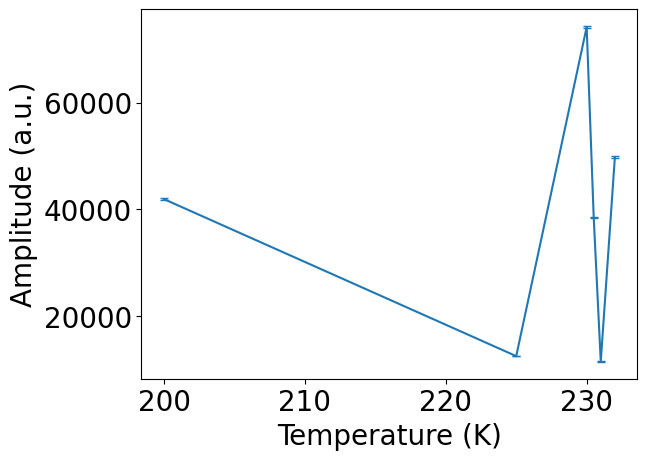

In [27]:
plt.figure()
plt.errorbar(df['temperature'], df['amplitude'], df['amplitude_error'], capsize=3)
plt.xlabel('Temperature (K)')
plt.ylabel('Amplitude (a.u.)')
plt.show()

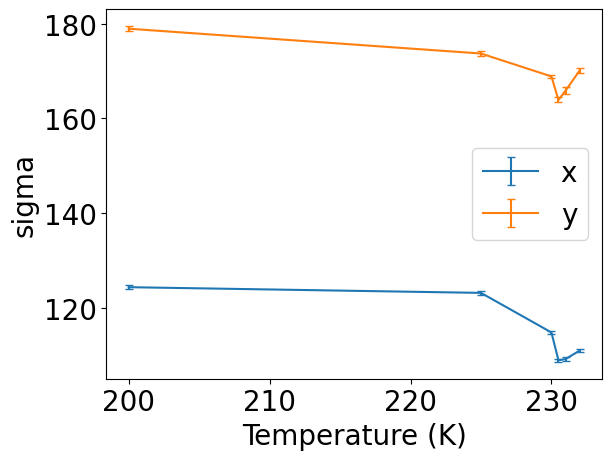

In [28]:
plt.figure()
plt.errorbar(df['temperature'], df['sigmax'], df['sigmax_error'], capsize=3, label='x')
plt.errorbar(df['temperature'], df['sigmay'], df['sigmay_error'], capsize=3, label='y')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('sigma')
plt.show()

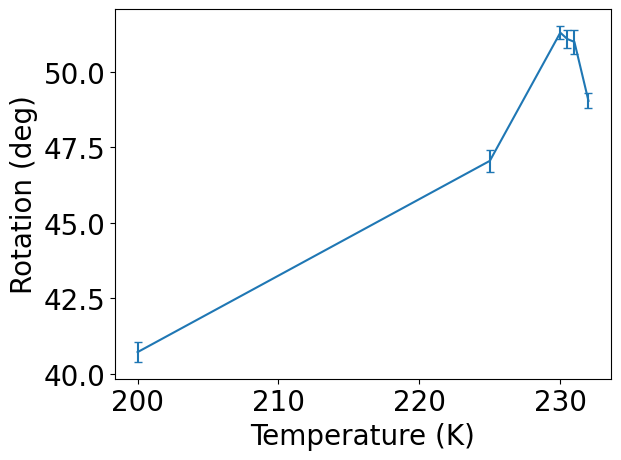

In [29]:
plt.figure()
plt.errorbar(df['temperature'], np.rad2deg(df['rotation']), np.rad2deg(df['rotation_error']), capsize=3)
plt.xlabel('Temperature (K)')
plt.ylabel('Rotation (deg)')
plt.show()

In [34]:
xi_x = 2 / df['sigmax']
xi_y = 2 / df['sigmay']

xi_x_err = xi_x * df['sigmax_error'] / df['sigmax']
xi_y_err = xi_y * df['sigmay_error'] / df['sigmay']

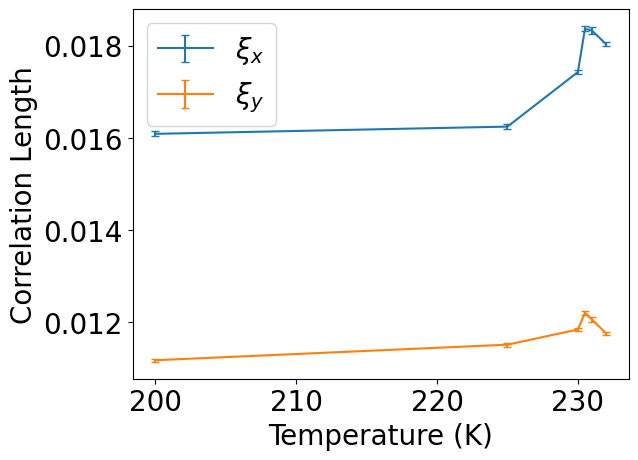

In [37]:
plt.figure()
plt.errorbar(df['temperature'], xi_x, xi_x_err, capsize=3, label=r'$\xi_x$')
plt.errorbar(df['temperature'], xi_y, xi_y_err, capsize=3, label=r'$\xi_y$')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Correlation Length')
plt.show()

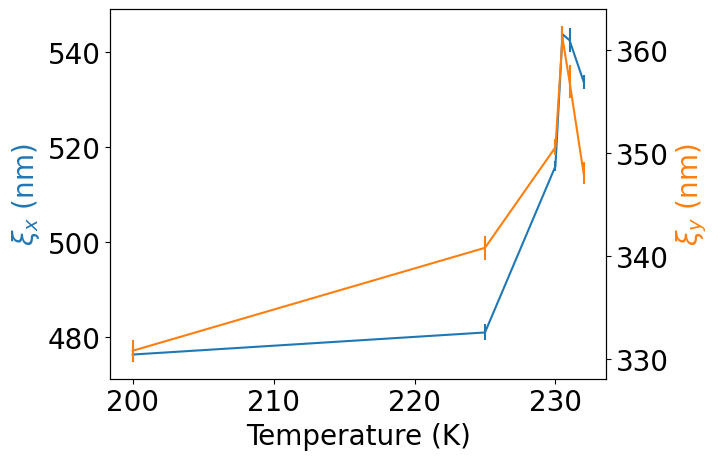

In [82]:
def hwhm_to_xi(hwhm, sample_distance, wavelength, pixel_size):
    from skbeam.core.utils import q_to_d, twotheta_to_q, radius_to_twotheta
    return q_to_d(twotheta_to_q(radius_to_twotheta(sample_distance, hwhm * pixel_size), wavelength))


def hwhm_to_xi_error(hwhm, hwhm_error, sample_distance, wavelength, pixel_size):
    #https://www.wolframalpha.com/input?i=derivative+with+respect+to+r+of+lambda+*+%282*sin%280.5*arctan%28p*r%2FD%29%29%29%5E%28-1%29
    deriv = ( 0.25 * sample_distance * wavelength * pixel_size * 1 / np.tan(0.5 * np.arctan( (hwhm * pixel_size) / sample_distance)) *\
    1 / np.sin(0.5 * np.arctan( (pixel_size* hwhm) / sample_distance)) ) / ( sample_distance ** 2 + pixel_size ** 2 * hwhm ** 2 )
    return deriv * hwhm_error


pixel_size = (20e-6, 20e-6) # m
sample_distance = 305e-3 # m
wavelength = (1240/638.7) #nm Mn L3

xi_x = fwhm_to_xi(df['sigmax']/2, sample_distance, wavelength, pixel_size[0])
xi_y = fwhm_to_xi(df['sigmay']/2, sample_distance, wavelength, pixel_size[0])


xi_x_err = fwhm_to_xi_error(df['sigmax']/2, df['sigmax_error']/2, sample_distance, wavelength, pixel_size[0])
xi_y_err = fwhm_to_xi_error(df['sigmay']/2, df['sigmay_error']/2, sample_distance, wavelength, pixel_size[0])


fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.errorbar(df['temperature'], xi_x, xi_x_err, c='C0')
ax1.errorbar(df['temperature'], xi_y, xi_y_err, c='C1')

ax.set_ylabel(r'$\xi_x$ (nm)', c='C0')
ax1.set_ylabel(r'$\xi_y$ (nm)', c='C1')
ax.set_xlabel('Temperature (K)')
plt.show()

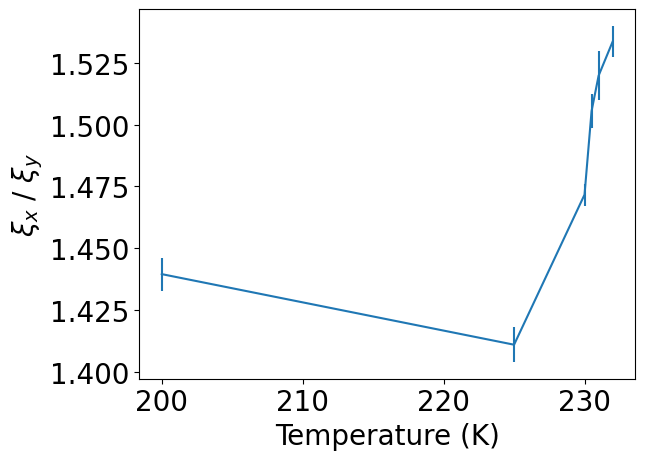

In [83]:
ratio = xi_x/xi_y
ratio_err = np.sqrt( (xi_x_err / xi_y)**2 + ((xi_x/xi_y**2) * xi_y_err)**2)

plt.figure()
plt.errorbar(df['temperature'], ratio, ratio_err)
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\xi_x$ / $\xi_y$')

plt.show()